<a href="https://colab.research.google.com/github/macontreras04/cpf/blob/main/Final_Prepayment_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Model Development/ALM - Case of Study**

##Candidate: Miguel Contreras

This Jupyter notebook presents the solution to the first part of the task. The data analysis was conducted using Python.


Firstly, it is necessary import the essential libraries, such as pandas, numpy, etc.

In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from datetime import datetime

The data below is read from a public Github. After that, both datasets are integrated into one table with all the data required to be analyzed.

In [12]:
url_mort = "https://raw.githubusercontent.com/macontreras04/cpf/main/mortgage_data.xlsx"

url_refr = "https://raw.githubusercontent.com/macontreras04/cpf/main/refinancing_rate_data.xlsx"


# Step 1: Load the data from URLs
data_mort = pd.read_excel(url_mort)
data_mort['Date'] = pd.to_datetime(data_mort['Date'], errors='coerce')

data_refr = pd.read_excel(url_refr)
data_refr['Date'] = pd.to_datetime(data_refr['Date'], errors='coerce')

# Step 2: Merge the data on 'Date'
data = pd.merge(data_mort, data_refr, how='left', on='Date')

# Step 3: Ensure 'Date' column is in datetime format and set it as the index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Step 4: Group by month and calculate the average prepayment and refinancing rates
monthly_prepayment_rate = data.groupby(data.index.to_period('M'))['PP_rate (%)'].mean().reset_index()
monthly_prepayment_rate['Date'] = monthly_prepayment_rate['Date'].dt.to_timestamp()

monthly_refinancing_rate = data.groupby(data.index.to_period('M'))['Refinancing rate'].mean().reset_index()
monthly_refinancing_rate['Date'] = monthly_refinancing_rate['Date'].dt.to_timestamp()

# Step 5: Calculate Refinancing Incentive and save to an Excel file
data['Refinancing Incentive'] = data['Client_rate (%)'] - data['Refinancing rate']

In [13]:
print(monthly_prepayment_rate.min(),monthly_prepayment_rate.max())

Date           2016-01-01 00:00:00
PP_rate (%)               0.003758
dtype: object Date           2018-12-01 00:00:00
PP_rate (%)               0.009911
dtype: object


## Creating the monthly aggregated prepayment for the mortgage portfolio

Before presenting the first plot required, the prepayment rate was summarized monthly using a simple average. The chart suggests using seasonal components to explain the behavior of the prepayment rates during that time.

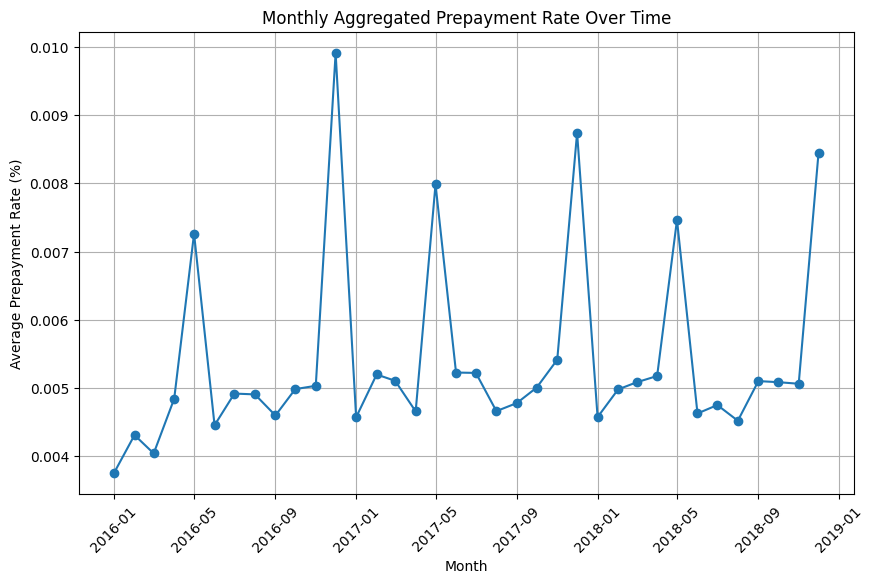

In [14]:
# Step 6: Plot the monthly aggregated prepayment rate
plt.figure(figsize=(10, 6))
plt.plot(monthly_prepayment_rate['Date'], monthly_prepayment_rate['PP_rate (%)'], marker='o', linestyle='-')
plt.xlabel('Month')
plt.ylabel('Average Prepayment Rate (%)')
plt.title('Monthly Aggregated Prepayment Rate Over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

The chart above illustrates an annual trend. It can be observed that every May and December the prepayment rate reached a peak. The maximum value was 1%, while the minimum value was nearly 0.38%.

When both time series, aggregated per month, are displayed in the same chart, it is worth noting that the refinancing rate has a negative downward trend. The relationship between the refinancing rate and the prepayment rate is generally inverse: as the refinancing rate decreases, the prepayment rate tends to increase. When the refinancing rate (the rate at which borrowers can refinance their existing loans) is lower than their current loan rate, borrowers are incentivized to prepay the existing loan and refinance into a new loan with more favorable terms. Lower refinancing rates increase the refinancing incentive, leading to higher prepayment rates as borrowers take advantage of the cost savings from refinancing.

## Plotting the monthly refinancing rate next to the prepayment rate

The chart below shows a non-linear relationship between the refinancing rate and the prepayment rate.

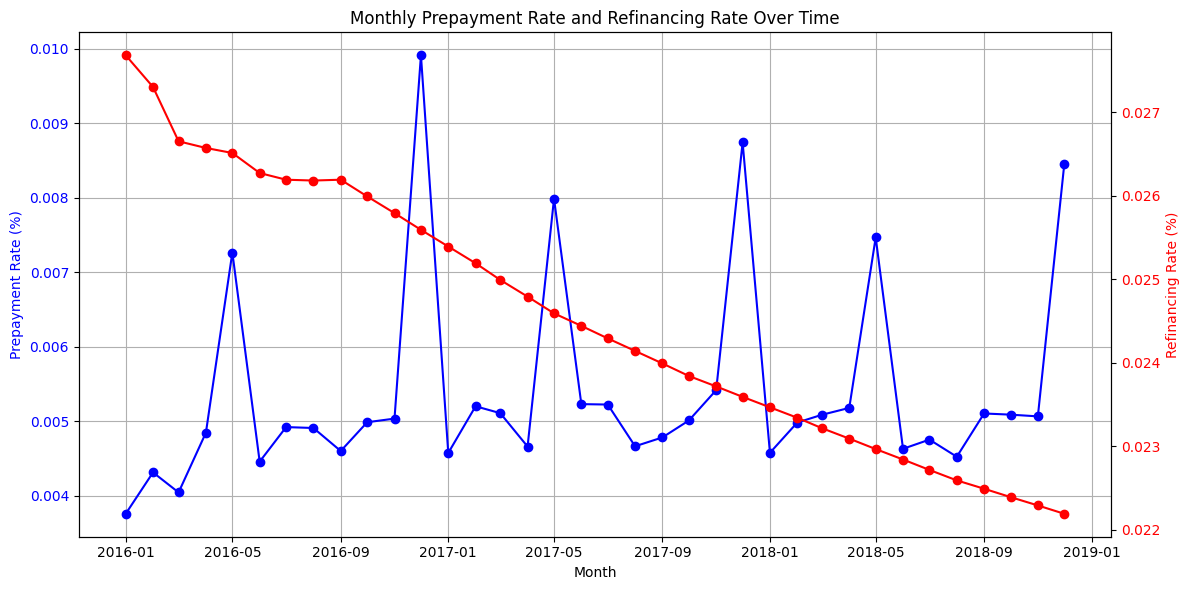

In [15]:
data_mort['Date'] = pd.to_datetime(data_mort['Date'], errors='coerce')

data_refr['Date'] = pd.to_datetime(data_refr['Date'], errors='coerce')

# Step 2: Merge the data on 'Date'
data = pd.merge(data_mort, data_refr, how='left', on='Date')

# Step 3: Ensure 'Date' column is in datetime format and set it as the index
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
data.set_index('Date', inplace=True)

# Step 4: Group by month and calculate the average prepayment and refinancing rates
monthly_prepayment_rate = data.groupby(data.index.to_period('M'))['PP_rate (%)'].mean().reset_index()
monthly_prepayment_rate['Date'] = monthly_prepayment_rate['Date'].dt.to_timestamp()

monthly_refinancing_rate = data.groupby(data.index.to_period('M'))['Refinancing rate'].mean().reset_index()
monthly_refinancing_rate['Date'] = monthly_refinancing_rate['Date'].dt.to_timestamp()

# Step 5: Calculate Refinancing Incentive
data['Refinancing Incentive'] = data['Client_rate (%)'] - data['Refinancing rate']

# Group by month and calculate the average prepayment rate and refinancing rate for each month
monthly_data = data.groupby(data.index.to_period('M')).agg({
    'PP_rate (%)': 'mean',
    'Refinancing rate': 'mean'
}).reset_index()

# Convert the period back to datetime format for plotting
monthly_data['Date'] = monthly_data['Date'].dt.to_timestamp()

# Plotting the monthly prepayment rate and refinancing rate together with independent scales
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotting the prepayment rate on the primary y-axis
ax1.plot(monthly_data['Date'], monthly_data['PP_rate (%)'], marker='o', linestyle='-', color='blue', label='Prepayment Rate (%)')
ax1.set_xlabel('Month')
ax1.set_ylabel('Prepayment Rate (%)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('Monthly Prepayment Rate and Refinancing Rate Over Time')

# Creating a secondary y-axis for the refinancing rate
ax2 = ax1.twinx()
ax2.plot(monthly_data['Date'], monthly_data['Refinancing rate'], marker='o', linestyle='-', color='red', label='Refinancing Rate (%)')
ax2.set_ylabel('Refinancing Rate (%)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Adding grid and adjusting the layout
ax1.grid(True)
fig.tight_layout()
plt.show()

## Calculating the refinancing incentive

The relevance on the refinancing incentive underlies the fact that it is a crucial variable to model the prepayment behavior. In financial terms, this is a benefit for the clients that weighs the decision whether to prepay or not. Customers with a high refinancing incentive tend to prepay their mortgages more than those without the incentive. In the chart below the refinancing rate is plotted for each client.
Refinancing affects prepayment timing by providing a financial benefit that motivates borrowers to prepay earlier than they might otherwise. This timing is driven by market conditions, interest rate sensitivity, cash flow needs, and borrower characteristics. Models that incorporate refinancing incentives can better predict when clusters of prepayments are likely to occur, aligning forecasts with borrower behavior in response to economic and financial incentives.


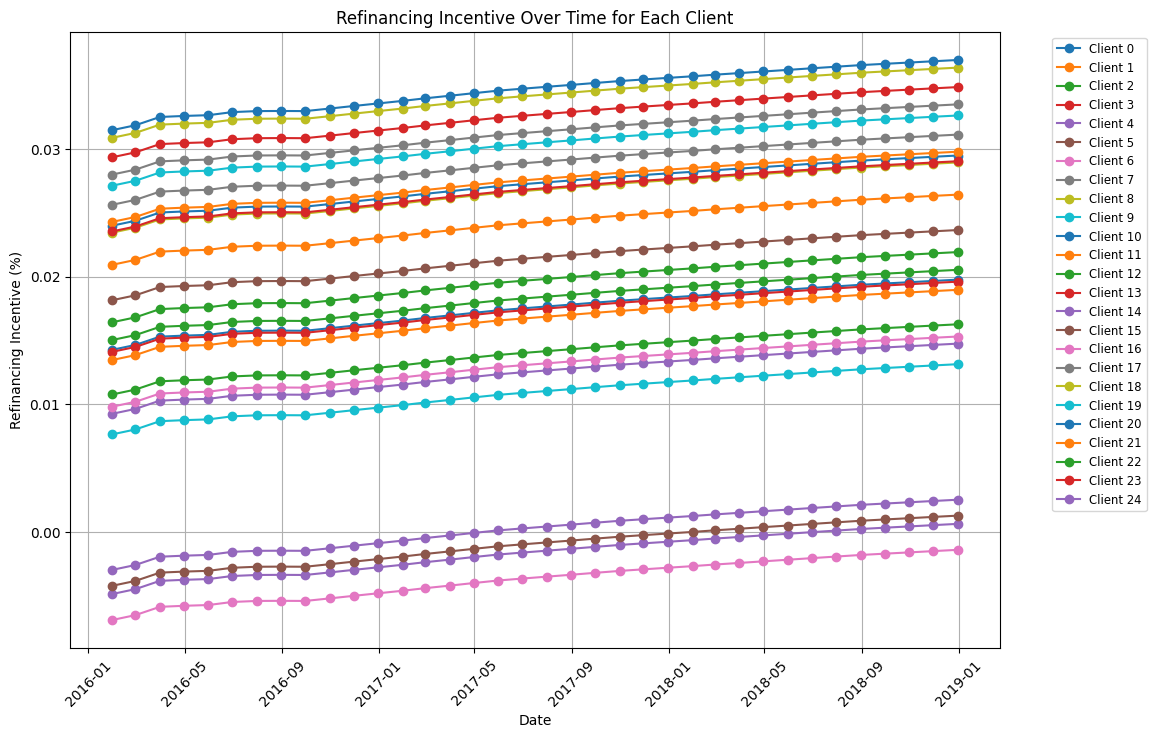

In [16]:
# Step 1: Load the data from URLs
data_mort = pd.read_excel(url_mort)
data_mort['Date'] = pd.to_datetime(data_mort['Date'], errors='coerce')

data_refr = pd.read_excel(url_refr)
data_refr['Date'] = pd.to_datetime(data_refr['Date'], errors='coerce')

# Step 2: Merge the data on 'Date'
data = pd.merge(data_mort, data_refr, how='left', on='Date')

# Step 3: Ensure 'Date' column is in datetime format and set it as the index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Step 4: Group by month and calculate the average prepayment and refinancing rates
monthly_prepayment_rate = data.groupby(data.index.to_period('M'))['PP_rate (%)'].mean().reset_index()
monthly_prepayment_rate['Date'] = monthly_prepayment_rate['Date'].dt.to_timestamp()

monthly_refinancing_rate = data.groupby(data.index.to_period('M'))['Refinancing rate'].mean().reset_index()
monthly_refinancing_rate['Date'] = monthly_refinancing_rate['Date'].dt.to_timestamp()

# Step 5: Calculate Refinancing Incentive and save to an Excel file
data['Refinancing Incentive'] = data['Client_rate (%)'] - data['Refinancing rate']
data.to_excel('data_prep.xlsx', index=False)



# Step 8: Plot the Refinancing Incentive over time for each client
plt.figure(figsize=(12, 8))
for client_id in data['Client_ID'].unique():
    client_data = data[data['Client_ID'] == client_id]
    plt.plot(client_data.index, client_data['Refinancing Incentive'], marker='o', linestyle='-', label=f'Client {client_id}')
plt.xlabel('Date')
plt.ylabel('Refinancing Incentive (%)')
plt.title('Refinancing Incentive Over Time for Each Client')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.show()


# **Modeling the prepayment rate with a logistic function**

The model selected to model properly is a sigmoid or logistic function. Firstly, modeling the prepayment rate as a constant is dismissed as per the previously analyzed chart. This is due to a non-linear interaction between the refinancing rate as well as seasonality during the time period. For the same reasons, a linear function does not capture the non-linear interactions. Besides the refinancing rate, which is a key component in the model, the loan age is the variable that represents the sigmoid. It will be discussed further. The rest explanatory variables were the notional repaid  and the monthly repayment. Finally, dummy variables were used to represent the seasonality effects observed in the chart during the time. In this part of the Python script, the modelling is performed. Also, a plot for each customer’s behavior is included.

<ipython-input-17-f145b07c5ff3>:22: RuntimeWarning: overflow encountered in exp
  logistic_component = L / (1 + np.exp(-k * (refinancing_incentive - x0)))
<ipython-input-17-f145b07c5ff3>:56: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_simplified, _ = curve_fit(simplified_logistic_model, x_data_client, y_data_client,
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


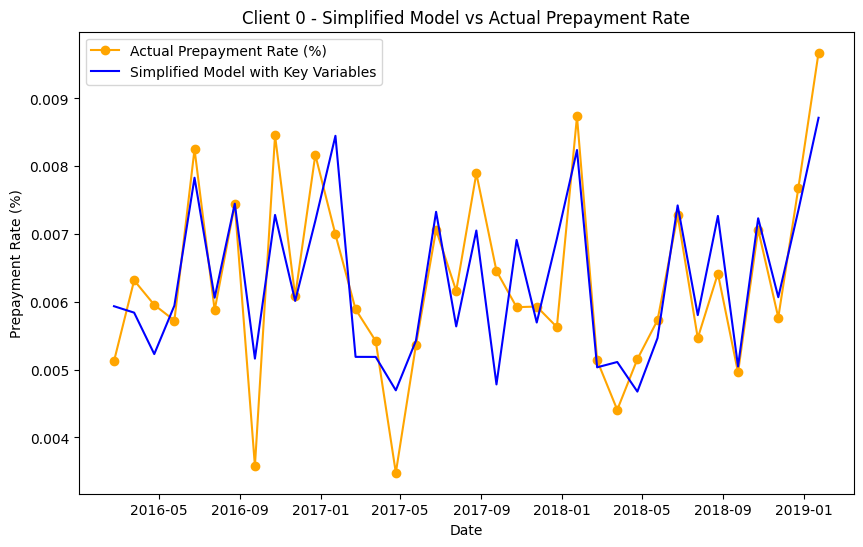

<ipython-input-17-f145b07c5ff3>:22: RuntimeWarning: overflow encountered in exp
  logistic_component = L / (1 + np.exp(-k * (refinancing_incentive - x0)))
<ipython-input-17-f145b07c5ff3>:56: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_simplified, _ = curve_fit(simplified_logistic_model, x_data_client, y_data_client,
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


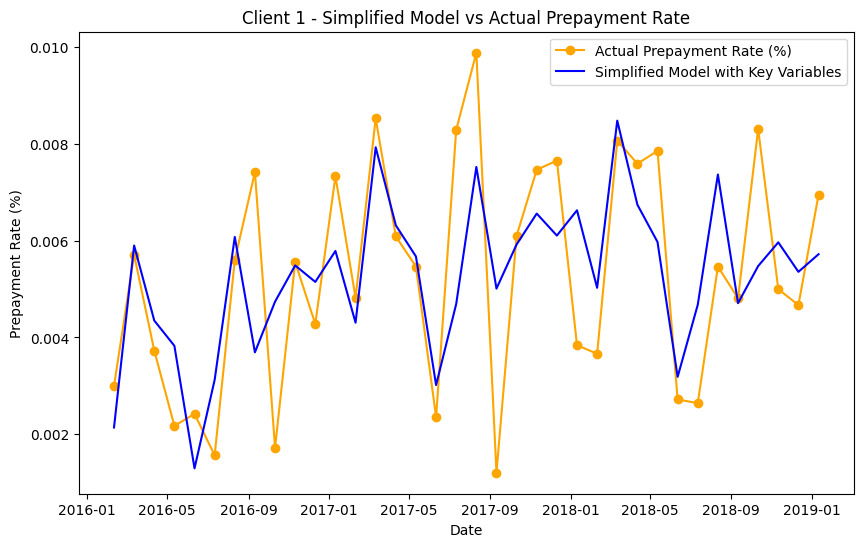

<ipython-input-17-f145b07c5ff3>:56: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_simplified, _ = curve_fit(simplified_logistic_model, x_data_client, y_data_client,


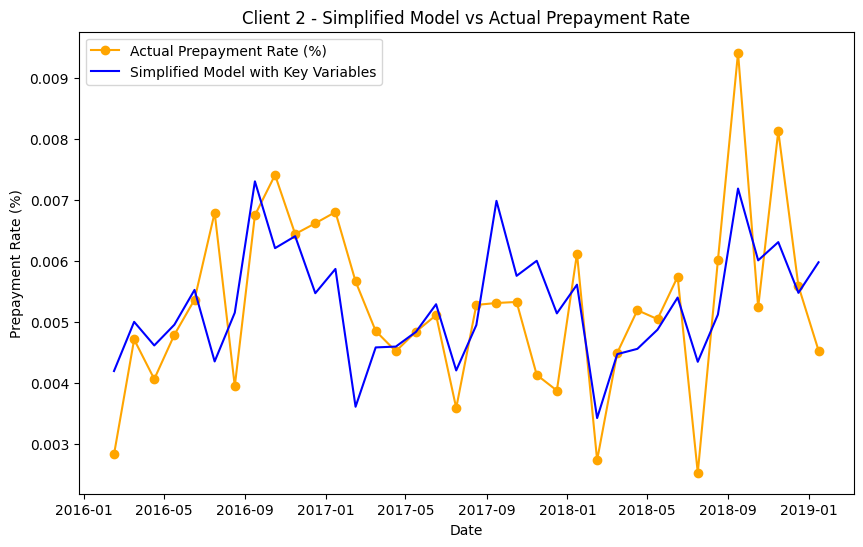

<ipython-input-17-f145b07c5ff3>:22: RuntimeWarning: overflow encountered in exp
  logistic_component = L / (1 + np.exp(-k * (refinancing_incentive - x0)))
<ipython-input-17-f145b07c5ff3>:56: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_simplified, _ = curve_fit(simplified_logistic_model, x_data_client, y_data_client,
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


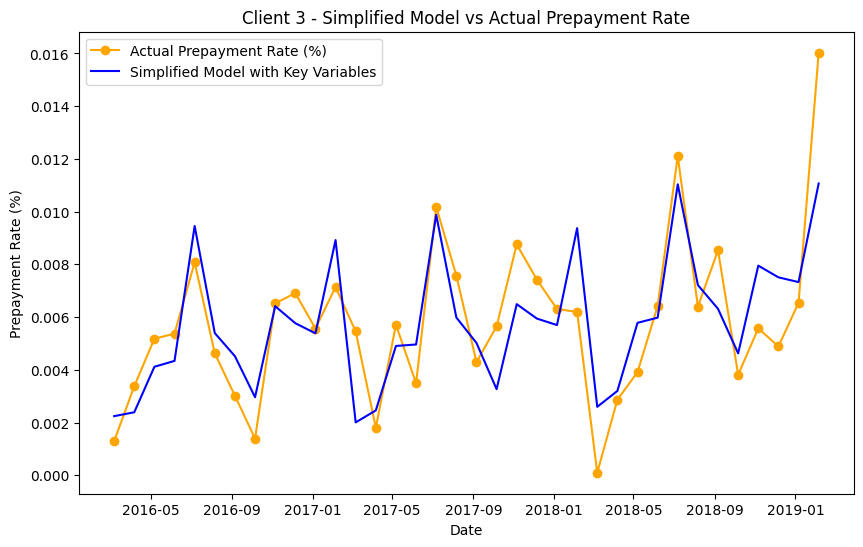

<ipython-input-17-f145b07c5ff3>:22: RuntimeWarning: overflow encountered in exp
  logistic_component = L / (1 + np.exp(-k * (refinancing_incentive - x0)))
<ipython-input-17-f145b07c5ff3>:56: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_simplified, _ = curve_fit(simplified_logistic_model, x_data_client, y_data_client,
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


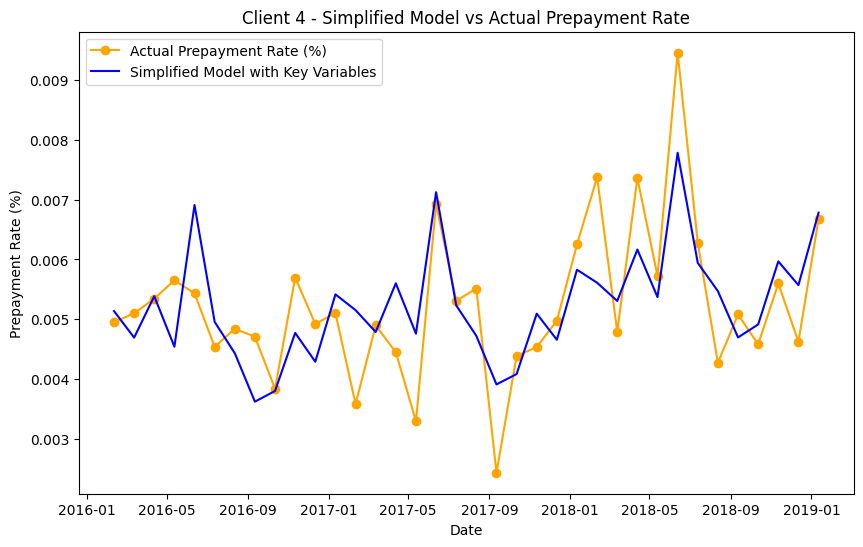

<ipython-input-17-f145b07c5ff3>:56: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_simplified, _ = curve_fit(simplified_logistic_model, x_data_client, y_data_client,


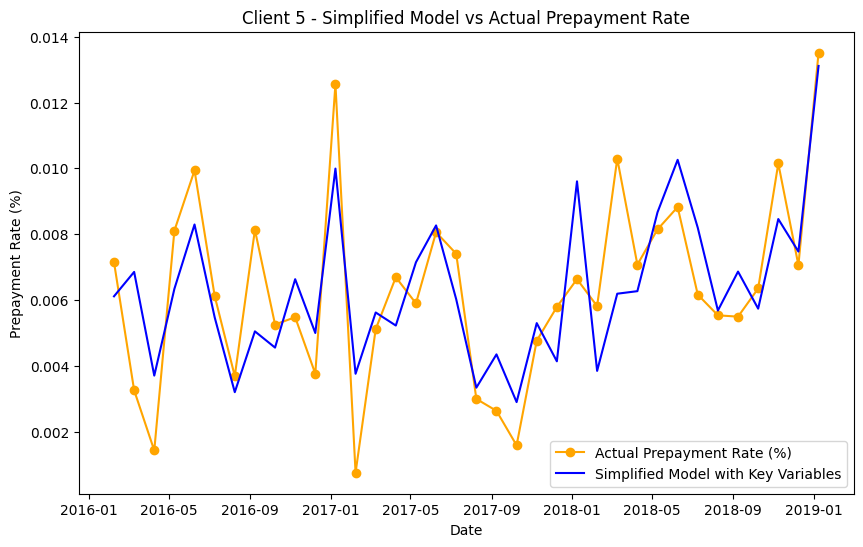

<ipython-input-17-f145b07c5ff3>:22: RuntimeWarning: overflow encountered in exp
  logistic_component = L / (1 + np.exp(-k * (refinancing_incentive - x0)))
<ipython-input-17-f145b07c5ff3>:56: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_simplified, _ = curve_fit(simplified_logistic_model, x_data_client, y_data_client,
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


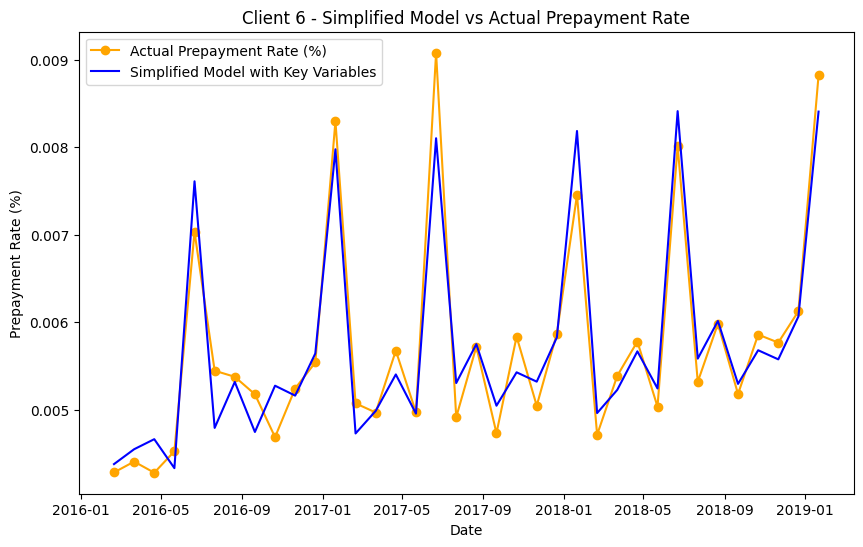

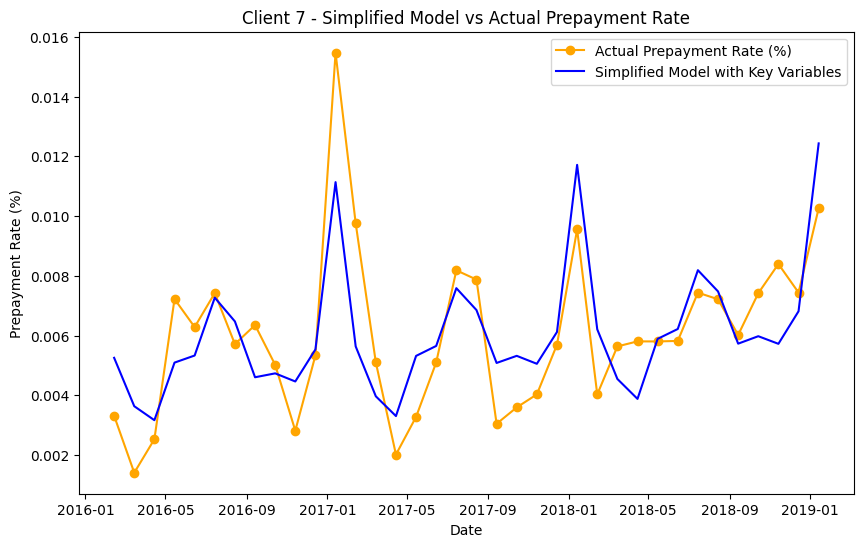

<ipython-input-17-f145b07c5ff3>:56: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_simplified, _ = curve_fit(simplified_logistic_model, x_data_client, y_data_client,


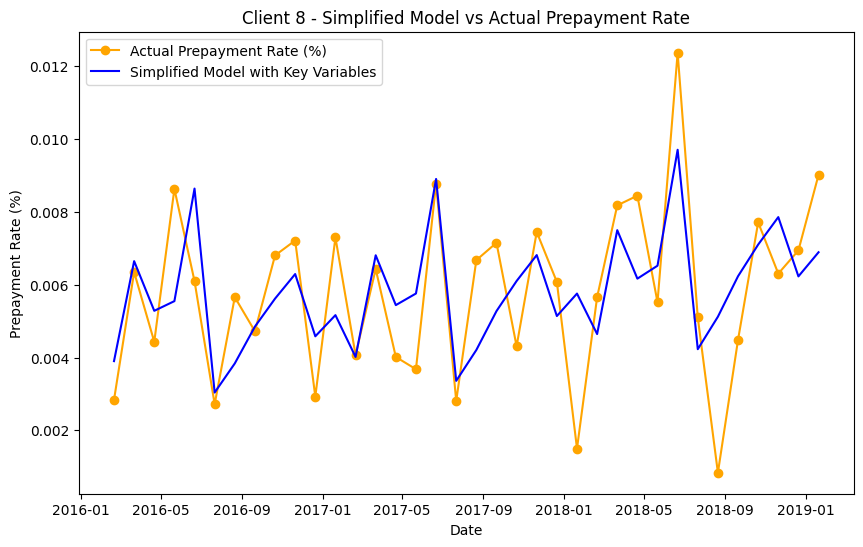

<ipython-input-17-f145b07c5ff3>:22: RuntimeWarning: overflow encountered in exp
  logistic_component = L / (1 + np.exp(-k * (refinancing_incentive - x0)))
<ipython-input-17-f145b07c5ff3>:56: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_simplified, _ = curve_fit(simplified_logistic_model, x_data_client, y_data_client,
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


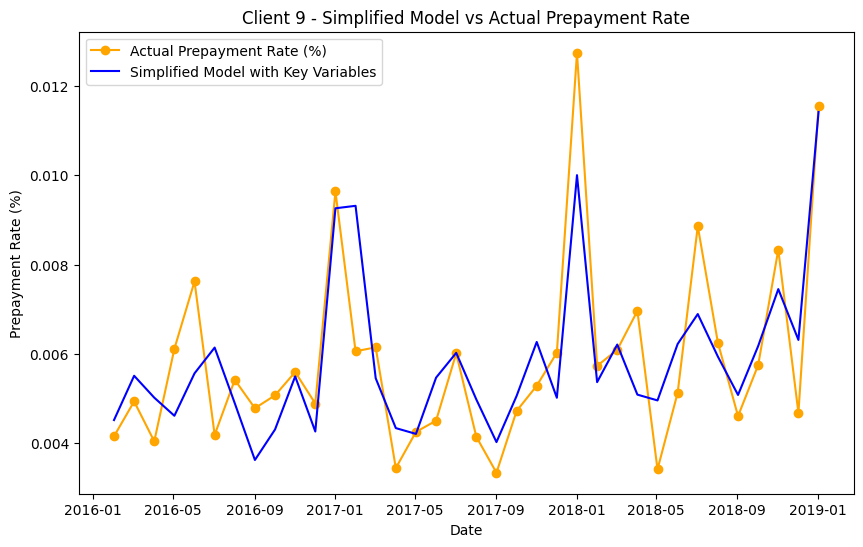

<ipython-input-17-f145b07c5ff3>:22: RuntimeWarning: overflow encountered in exp
  logistic_component = L / (1 + np.exp(-k * (refinancing_incentive - x0)))
<ipython-input-17-f145b07c5ff3>:56: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_simplified, _ = curve_fit(simplified_logistic_model, x_data_client, y_data_client,


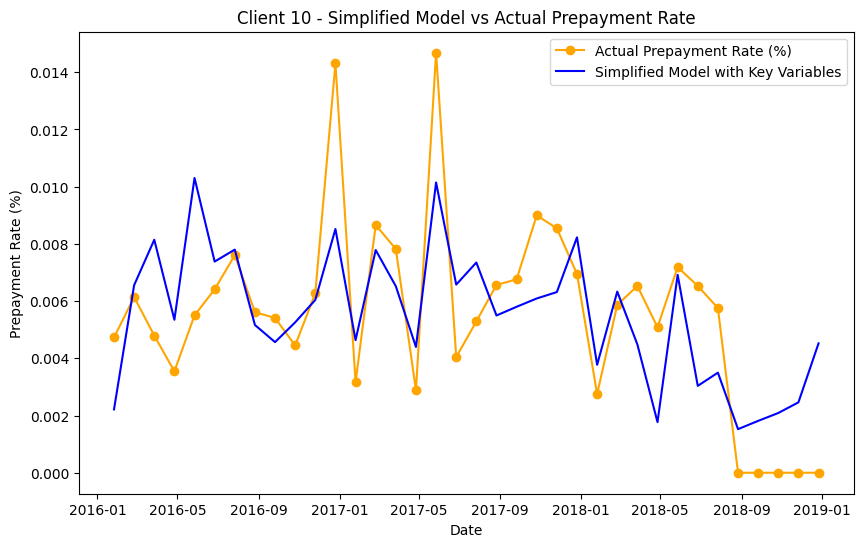

<ipython-input-17-f145b07c5ff3>:22: RuntimeWarning: overflow encountered in exp
  logistic_component = L / (1 + np.exp(-k * (refinancing_incentive - x0)))
<ipython-input-17-f145b07c5ff3>:56: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_simplified, _ = curve_fit(simplified_logistic_model, x_data_client, y_data_client,
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


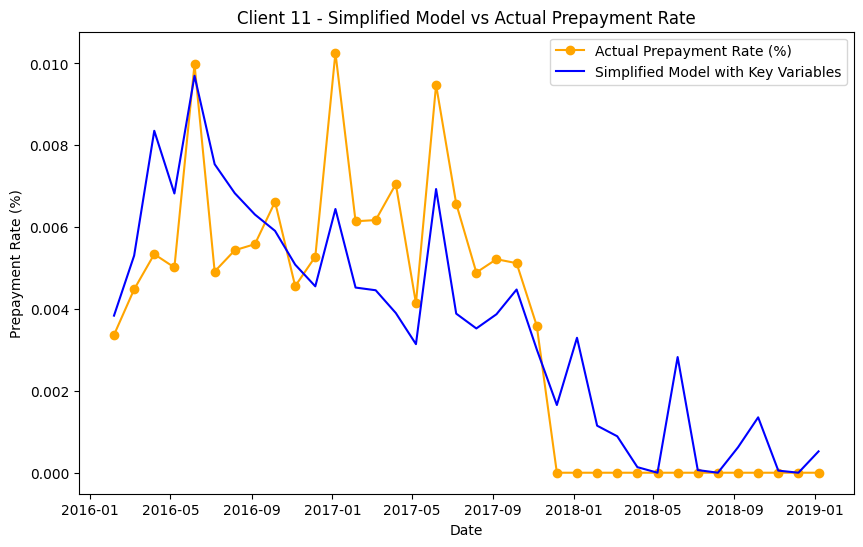

<ipython-input-17-f145b07c5ff3>:56: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_simplified, _ = curve_fit(simplified_logistic_model, x_data_client, y_data_client,


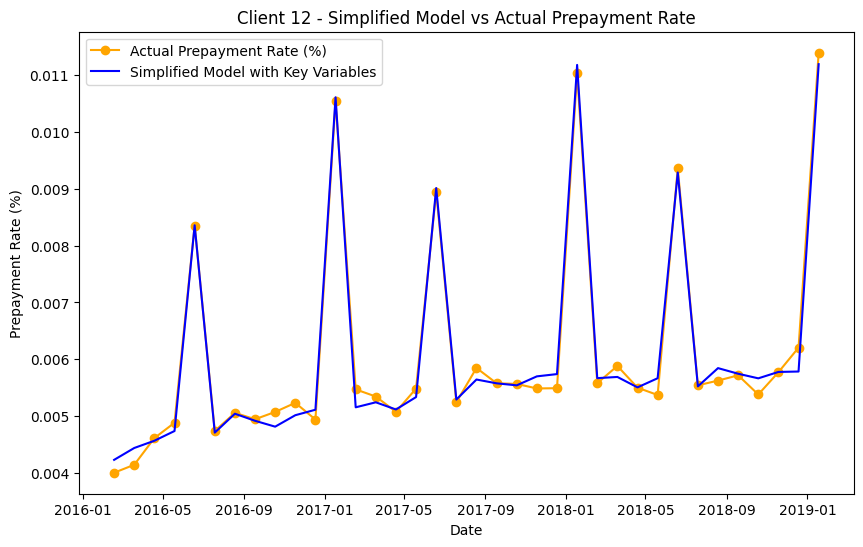

<ipython-input-17-f145b07c5ff3>:56: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_simplified, _ = curve_fit(simplified_logistic_model, x_data_client, y_data_client,


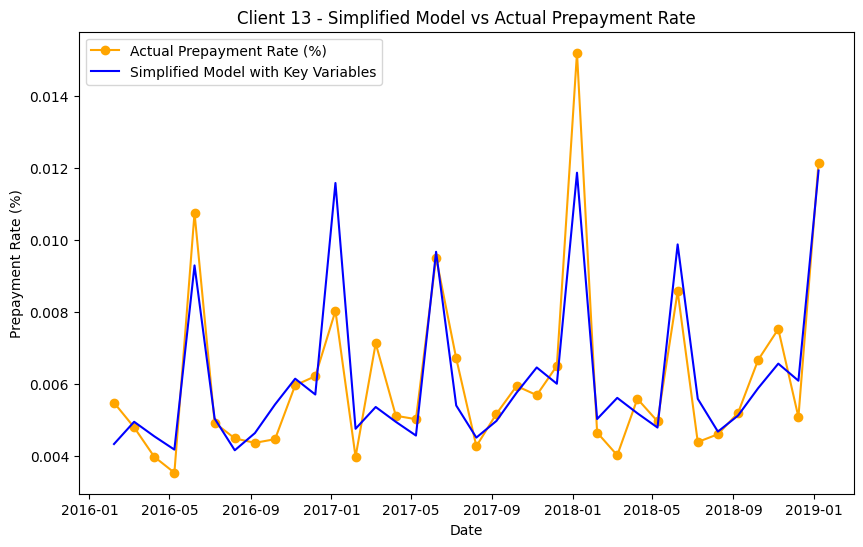

<ipython-input-17-f145b07c5ff3>:22: RuntimeWarning: overflow encountered in exp
  logistic_component = L / (1 + np.exp(-k * (refinancing_incentive - x0)))
<ipython-input-17-f145b07c5ff3>:56: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_simplified, _ = curve_fit(simplified_logistic_model, x_data_client, y_data_client,
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


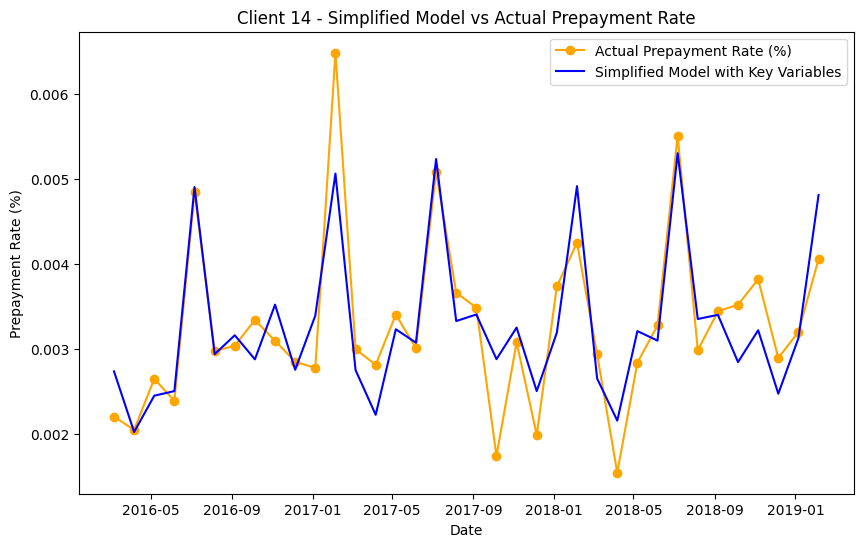

<ipython-input-17-f145b07c5ff3>:56: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_simplified, _ = curve_fit(simplified_logistic_model, x_data_client, y_data_client,


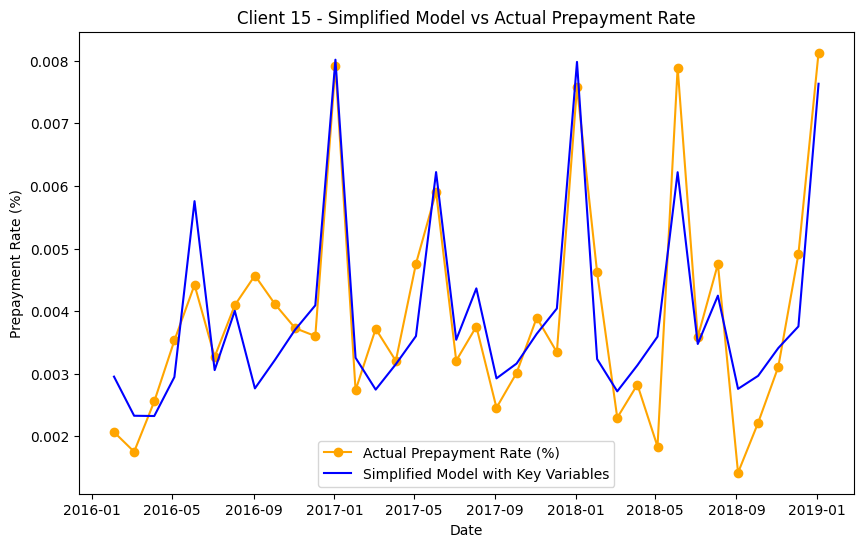

<ipython-input-17-f145b07c5ff3>:56: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_simplified, _ = curve_fit(simplified_logistic_model, x_data_client, y_data_client,


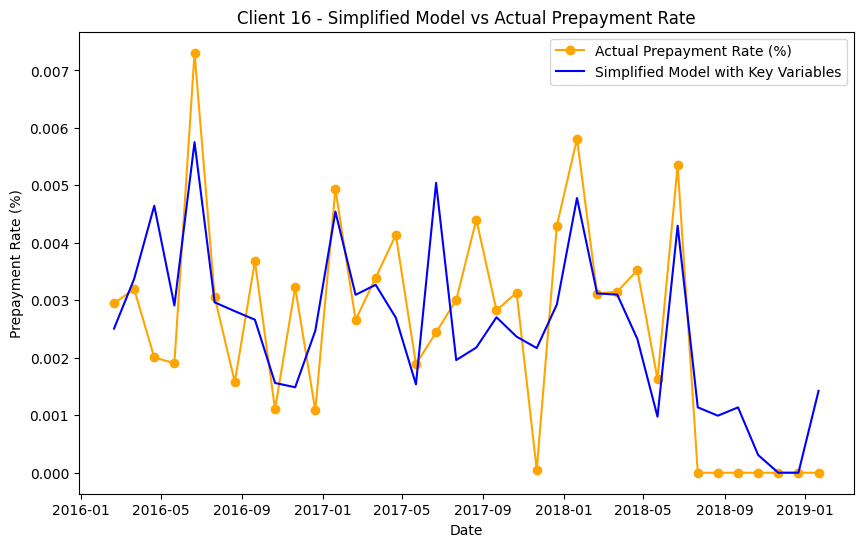

<ipython-input-17-f145b07c5ff3>:56: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_simplified, _ = curve_fit(simplified_logistic_model, x_data_client, y_data_client,


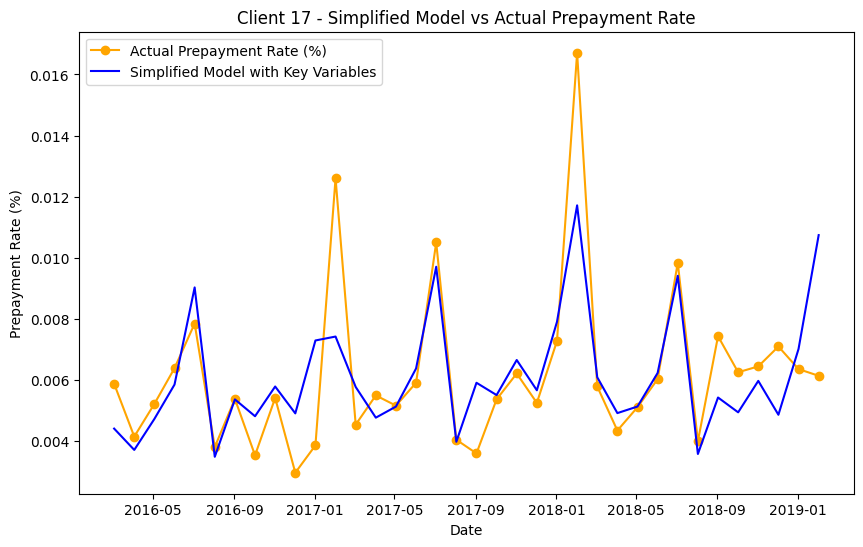

<ipython-input-17-f145b07c5ff3>:56: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_simplified, _ = curve_fit(simplified_logistic_model, x_data_client, y_data_client,


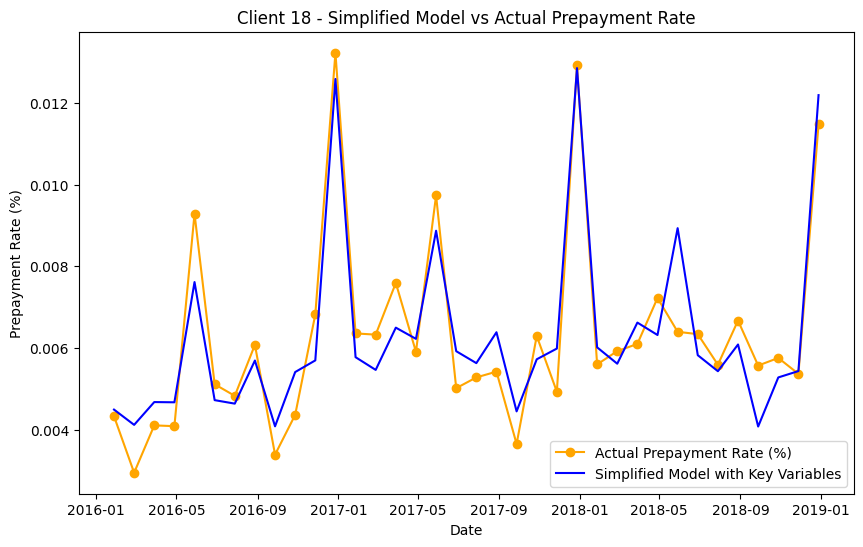

<ipython-input-17-f145b07c5ff3>:22: RuntimeWarning: overflow encountered in exp
  logistic_component = L / (1 + np.exp(-k * (refinancing_incentive - x0)))


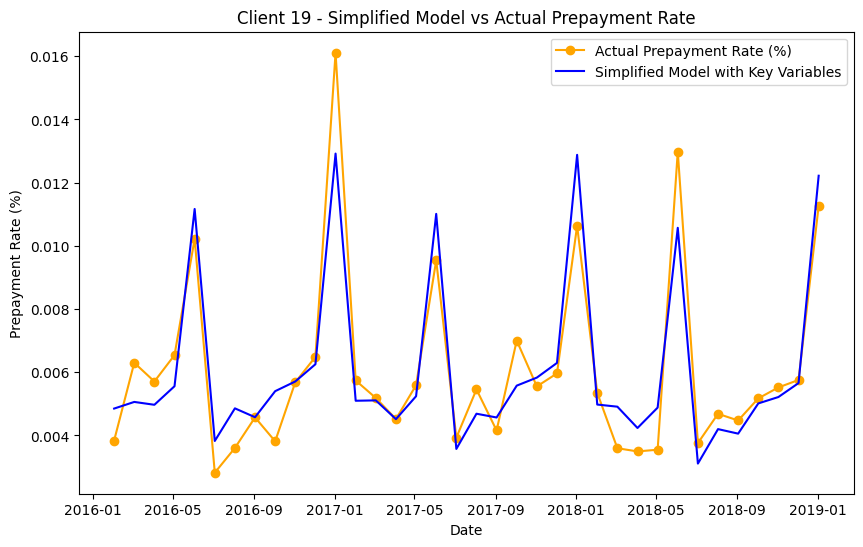

<ipython-input-17-f145b07c5ff3>:22: RuntimeWarning: overflow encountered in exp
  logistic_component = L / (1 + np.exp(-k * (refinancing_incentive - x0)))
<ipython-input-17-f145b07c5ff3>:56: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_simplified, _ = curve_fit(simplified_logistic_model, x_data_client, y_data_client,
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


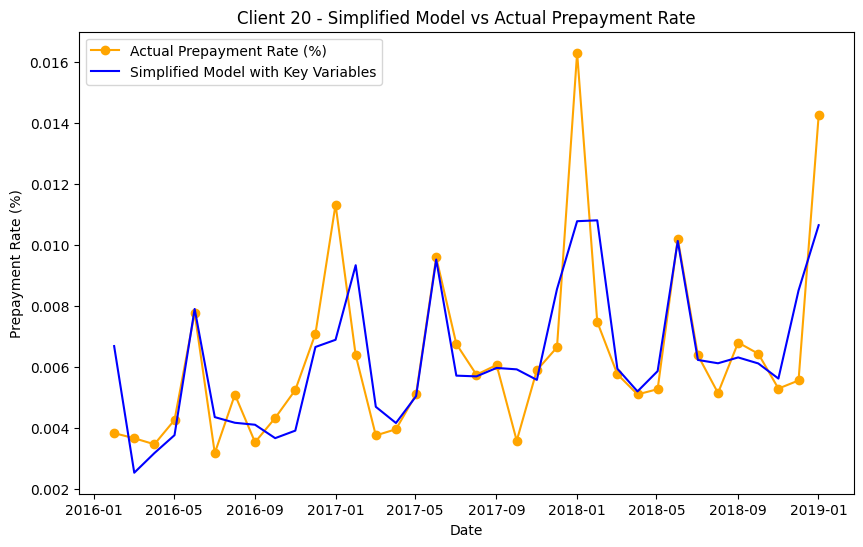

<ipython-input-17-f145b07c5ff3>:56: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_simplified, _ = curve_fit(simplified_logistic_model, x_data_client, y_data_client,


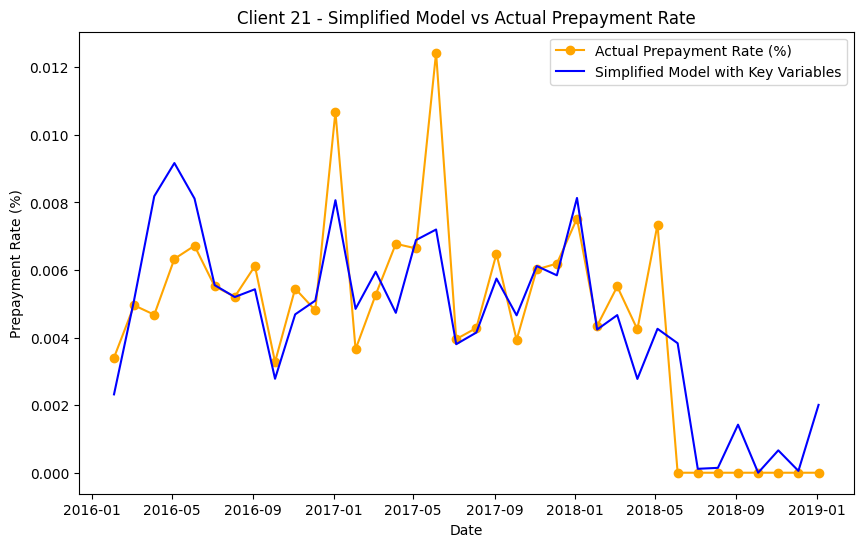

<ipython-input-17-f145b07c5ff3>:22: RuntimeWarning: overflow encountered in exp
  logistic_component = L / (1 + np.exp(-k * (refinancing_incentive - x0)))
<ipython-input-17-f145b07c5ff3>:56: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_simplified, _ = curve_fit(simplified_logistic_model, x_data_client, y_data_client,
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


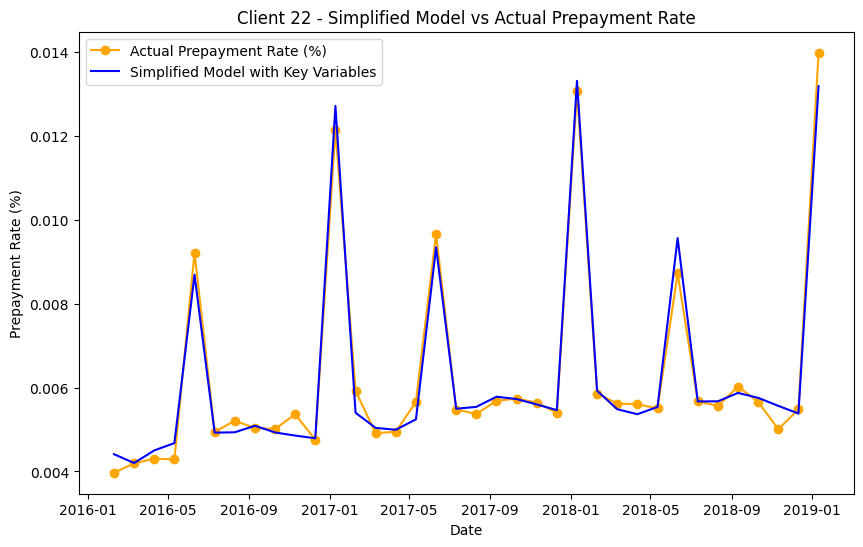

<ipython-input-17-f145b07c5ff3>:22: RuntimeWarning: overflow encountered in exp
  logistic_component = L / (1 + np.exp(-k * (refinancing_incentive - x0)))
<ipython-input-17-f145b07c5ff3>:56: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_simplified, _ = curve_fit(simplified_logistic_model, x_data_client, y_data_client,
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


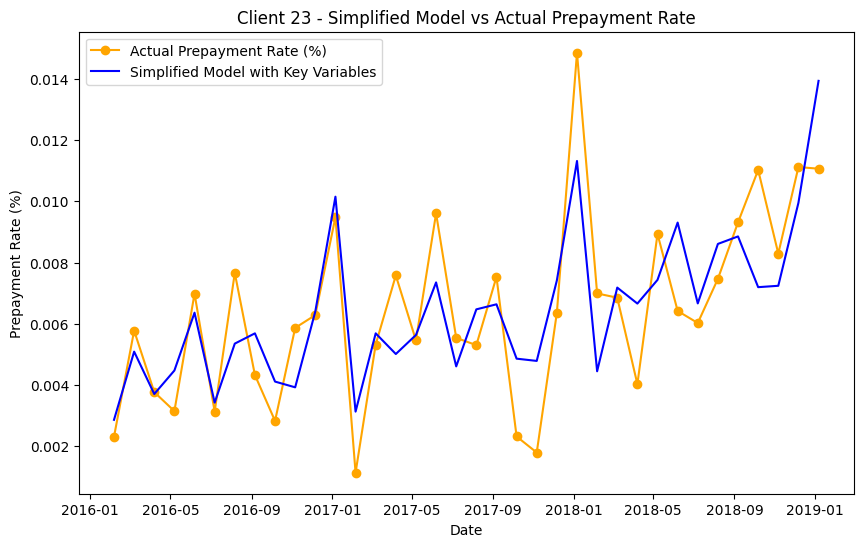

<ipython-input-17-f145b07c5ff3>:56: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_simplified, _ = curve_fit(simplified_logistic_model, x_data_client, y_data_client,


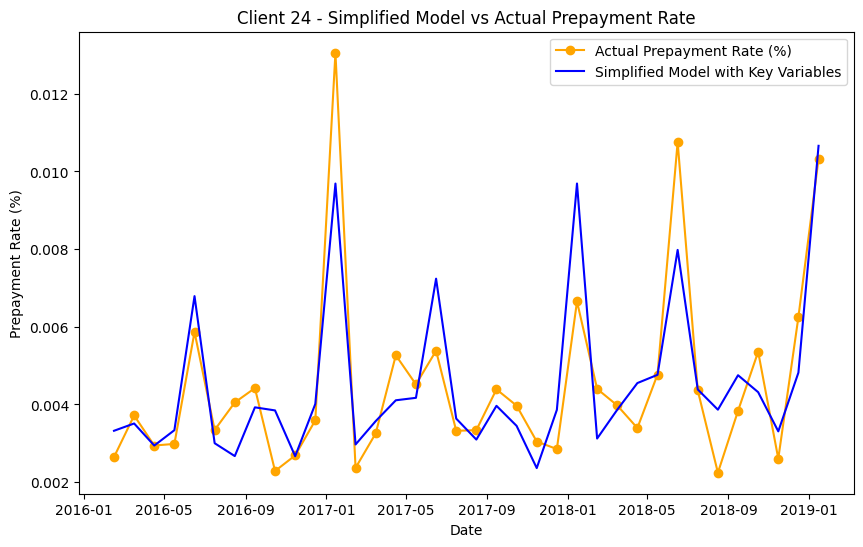

In [17]:
# Preprocess data
data['Loan_start_date'] = pd.to_datetime(data['Loan_start_date'])
data['Loan_end_date'] = pd.to_datetime(data['Loan_end_date'])
data['Total_loan_term_months'] = ((data['Loan_end_date'] - data['Loan_start_date']).dt.days / 30.44).round()
data['Loan_age_months'] = data['Total_loan_term_months'] - data['Remaining_maturity (M)']
data['Record_date'] = data['Loan_start_date'] + pd.to_timedelta(data['Loan_age_months'] * 30.44, unit='D')
data['Principal_Repaid'] = data['Starting_notional'] - data['Outstanding_notional']
data['Monthly_Repayment'] = data['Outstanding_notional'].shift(1) - data['Outstanding_notional']
data['Monthly_Repayment'] = data['Monthly_Repayment'].fillna(0)

# Add monthly dummies for seasonality
for month in range(1, 13):
    data[f'Month_{month}'] = (data['Record_date'].dt.month == month).astype(int)

# Define the simplified logistic model function with reduced explanatory variables and key interactions
def simplified_logistic_model(x, L, k, x0, beta, gamma, delta, epsilon, *monthly_effects):
    # Unpack base variables
    loan_age, refinancing_incentive, outstanding_notional, principal_repaid = x[:4]
    monthly_dummies = x[4:]  # Monthly dummy variables

    # Logistic component based on Loan Age
    logistic_component = L / (1 + np.exp(-k * (refinancing_incentive - x0)))

    # Monthly seasonality effect
    monthly_effect = sum(effect * dummy for effect, dummy in zip(monthly_effects, monthly_dummies))

    # Key predictor and interaction effects
    predictors_effect = (beta * refinancing_incentive +
                         gamma * outstanding_notional +
                         delta * principal_repaid +
                         epsilon * loan_age)

    return logistic_component + monthly_effect + predictors_effect

# Define initial guesses for simplified model parameters
initial_guess_simplified = [0.05, 0.1, 12, 0.01, 0.01, 0.01, 0.001] + [0.005] * 12

# Loop through each client and fit the simplified model
client_ids = data['Client_ID'].unique()
for client_id in client_ids:
    # Filter data for the current client
    client_data = data[data['Client_ID'] == client_id].copy()
    client_data['Time'] = (client_data['Record_date'] - client_data['Record_date'].min()).dt.days / 30.44  # Convert to months

    # Prepare input data for the simplified model
    x_data_client = [
        client_data['Loan_age_months'],
        client_data['Refinancing Incentive'],
        client_data['Outstanding_notional'],
        client_data['Principal_Repaid']
    ] + [client_data[f'Month_{month}'] for month in range(1, 13)]
    y_data_client = client_data['PP_rate (%)']

    # Fit the simplified model for the client
    try:
        popt_simplified, _ = curve_fit(simplified_logistic_model, x_data_client, y_data_client,
                                       p0=initial_guess_simplified, maxfev=10000)

        # Calculate fitted values using the optimized model parameters
        fitted_values_simplified = simplified_logistic_model(x_data_client, *popt_simplified)

        # Apply a floor to the fitted values to ensure non-negative prepayment rates
        fitted_values_simplified = np.maximum(fitted_values_simplified, 0)

        # Plot actual Prepayment Rate and fitted model for each client using Record_date as the x-axis
        plt.figure(figsize=(10, 6))
        plt.plot(client_data['Record_date'], y_data_client, label='Actual Prepayment Rate (%)', color='orange', marker='o')
        plt.plot(client_data['Record_date'], fitted_values_simplified, label='Simplified Model with Key Variables', color='blue')

        # Adding labels, title, and legend
        plt.xlabel('Date')
        plt.ylabel('Prepayment Rate (%)')
        plt.title(f'Client {client_id} - Simplified Model vs Actual Prepayment Rate')
        plt.legend()

        # Display the plot
        plt.show()

    except Exception as e:
        print(f"An error occurred while fitting the simplified model for Client {client_id}: {e}")

Alternative models could be used instead of a sigmoid as suggested in the case of study, such as a time series model, a seasonal ARIMA for instance. But the idea of suggesting a sigmoid is very particular. The idea behind developing  a model for representing the behavior of the prepayment rate is not just to put some variables that forecast future behavior. It is necessary that the model accounts for economic interpretability of how customers are incentivised to prepay when the refinancing incentive reaches some level. Also, the relationships between all the variables included in the dataset should be taken into count. A sigmoid function is a well-known model in the mortgage prepayment model literature. In many cases, the relationship between loan age and the prepayment rate can resemble an S-shaped curve (sigmoid curve), particularly for certain types of loans such as mortgages. This is commonly seen due to borrower behavior over the life of the loan:

**Early Period (Slow Start):** Prepayments tend to be lower during the initial period, as borrowers are less likely to refinance or pay off a new loan.

**Middle Period (Acceleration):** As the loan ages, borrowers are more likely to refinance or prepay due to life events, equity buildup, or lower interest rates. This is where the prepayment rate may increase significantly.

**Late Period (Saturation/Plateau):** Towards the end of the loan, prepayment activity may plateau as the remaining balance is smaller and refinancing incentives diminish.

The overall model combines the logistic function with additional variables and interaction terms to provide a comprehensive view of prepayment rates. Each variable captures different economic and borrower-driven dynamics.

**Variables in the Final Model**

**Loan Age:**
Role: Represents the time that has passed since the loan’s origination, typically measured in months.

Economic Interpretation: Loan age captures the borrower’s position in the loan lifecycle. Early in the loan term, borrowers are less likely to prepay due to initial setup costs or prepayment penalties. However, as the loan ages, the likelihood of prepayment generally increases. This is because:

Reduction in Penalties: Many loans have prepayment penalties that decrease or disappear over time, making prepayment more appealing as the loan matures.
Accumulated Equity: Over time, borrowers accumulate equity, which can make refinancing or prepaying more financially feasible or desirable.

Lifestyle and Financial Changes: Borrowers' financial situations may evolve over time (e.g., increased income or job stability), allowing for more frequent or larger payments, leading to higher prepayment rates in later stages.

In the logistic model, Loan Age drives the underlying trend in prepayment behavior, with the sigmoid curve capturing the pattern of gradual acceleration in prepayment rates followed by a leveling off as the loan approaches maturity.

**Seasonality (Monthly Dummy Variables):**
Role: Each month is represented by a dummy variable (e.g., Month_1 for January, Month_2 for February, etc.), allowing the model to adjust prepayment rates based on specific times of the year.

Economic Interpretation: These dummies capture cyclic or seasonal behaviors not directly tied to loan age. For example, higher prepayments may occur in the months when borrowers receive bonuses or tax returns, or during low-spending periods (e.g., post-holiday season).

**Refinancing Incentive:**
Role: This variable indicates the borrower’s financial benefit from refinancing the loan at a lower rate.

Economic Interpretation: The refinancing incentive is a powerful predictor of prepayment. When refinancing rates are lower than the existing loan rate, borrowers are incentivized to prepay and refinance, which drives higher prepayment rates.

**Outstanding Notional:**
Role: Represents the remaining loan balance.

Economic Interpretation: A higher outstanding balance may discourage prepayment due to higher transaction costs and fees. Conversely, as this balance decreases, the likelihood of prepayment may increase as the remaining financial commitment becomes smaller.

**Principal Repaid:**
Role: Cumulative amount of principal that has been paid down.

Economic Interpretation: As more principal is repaid, borrowers might be more inclined to pay off the remaining balance, especially if the loan is close to being fully repaid. These variable captures borrower progress in paying down debt and may be linked to borrower motivation to clear debt faster.


**Summing Up**

The final model is a combination of the logistic growth function and additional linear, nonlinear, and interaction terms, forming a flexible model capable of capturing a wide range of prepayment behaviours.

Each variable plays a unique role in explaining or predicting prepayment rates, balancing economic incentives with borrower behaviour and seasonality to provide a comprehensive prepayment forecast.

